In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import math
import sys

In [ ]:
#image_path
img_path="../img/roteted.jpg"
 
#read image
img_raw = cv2.imread(img_path ,0)

#select ROI function
roi = cv2.selectROI(img_raw)
 
#print rectangle points of selected roi
print(roi)
 
#Crop selected roi from raw image
roi_cropped = img_raw[int(roi[1]):int(roi[1]+roi[3]), int(roi[0]):int(roi[0]+roi[2])]
 
#show cropped image
#cv2.imshow("ROI", roi_cropped)
 
cv2.imwrite("crop.jpeg",roi_cropped)
 
#hold window
cv2.waitKey(0)
cv2.destroyAllWindows()

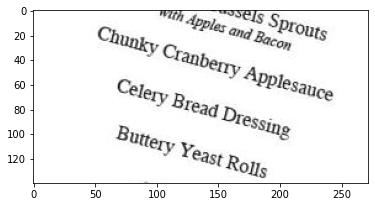

In [2]:
img = cv2.imread('../img/crop.jpeg' ,0)
plt.imshow(img ,cmap='gray')

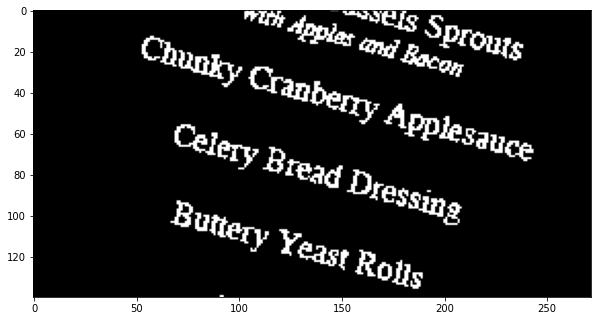

In [3]:
### OTSU THRESHOLD
neg = 255 - img
retval, thresh = cv2.threshold(neg,50,255,cv2.THRESH_BINARY)


plt.figure(figsize=(10,10))
plt.imshow(thresh ,cmap='gray')

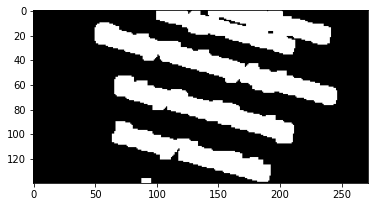

In [4]:
### DILATION
kernel = np.ones((7,7), np.uint8) 
img_dilation = cv2.dilate(thresh, kernel, iterations=1) 

plt.imshow(img_dilation ,cmap='gray') 

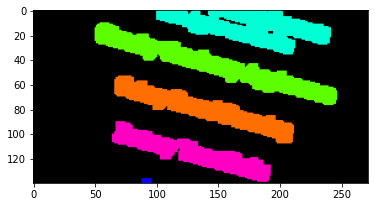

In [5]:
## Connected componants 

num_labels, labels_im = cv2.connectedComponents(img_dilation)
def imshow_components(labels):

    label_hue = np.uint8(179*labels/np.max(labels))
    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

    labeled_img[label_hue==0] = 0

    plt.imshow(labeled_img)

imshow_components(labels_im)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


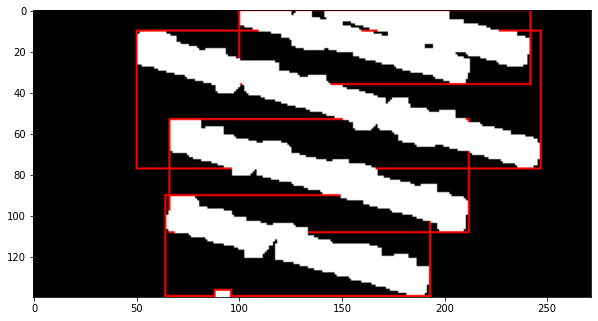

In [6]:

def get_bounding_boxes_img(num_labels ,labels_im):
    ops = []
    
    for label in range(1,num_labels):
        comp = labels_im.copy()

        for i in range(labels_im.shape[0]):
            for j in range(labels_im.shape[1]):

                if comp[i][j] == label:
                    comp[i][j] = 255
                else:
                    comp[i][j] = 0

        comp = np.stack((comp,)*3, axis=-1)

        active_px = np.argwhere(comp!=0)
        active_px = active_px[:,[1,0]]
        
        x,y,w,h = cv2.boundingRect(active_px)
        
        op = cv2.rectangle(comp,(x,y),(x+w,y+h),(255,0,0),1)
        ops.append(op)
        
    res = ops[0]
    
    for i in range(1,len(ops)):
        res += ops[i]
    
    plt.figure(figsize = (10,10))
    plt.imshow(res)
        
        

num_labels, labels_im = cv2.connectedComponents(img_dilation)
get_bounding_boxes_img(num_labels ,labels_im)


In [7]:

def get_bounding_boxes(num_labels ,labels_im):
    componants = []

    for label in range(1,num_labels):
        comp = labels_im.copy()

        for i in range(labels_im.shape[0]):
            for j in range(labels_im.shape[1]):

                if comp[i][j] == label:
                    comp[i][j] = 255
                else:
                    comp[i][j] = 0

        comp = np.stack((comp,)*3, axis=-1)

        active_px = np.argwhere(comp!=0)
        active_px = active_px[:,[1,0]]

        x,y,w,h = cv2.boundingRect(active_px)
        componants.append( (label,w,h ,x,y))
    
    return componants

In [8]:
def rotate_image(mat, angle):
    height, width = mat.shape[:2]
    image_center = (width / 2, height / 2)

    rotation_mat = cv2.getRotationMatrix2D(image_center, angle, 1)

    radians = math.radians(angle)
    sin = math.sin(radians)
    cos = math.cos(radians)
    bound_w = int((height * abs(sin)) + (width * abs(cos)))
    bound_h = int((height * abs(cos)) + (width * abs(sin)))

    rotation_mat[0, 2] += ((bound_w / 2) - image_center[0])
    rotation_mat[1, 2] += ((bound_h / 2) - image_center[1])

    rotated_mat = cv2.warpAffine(mat, rotation_mat, (bound_w, bound_h))
    return rotated_mat



def featureless_rotation(img):
    
    aspect_ratios = []

    for angle in range(1,30):

        #res = rotate_image(img_dilation ,angle)
        image_center = tuple(np.array(img.shape[1::-1]) / 2)
        rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
        res = cv2.warpAffine(img, rot_mat, img.shape[1::-1], flags=cv2.INTER_LINEAR)

        num_labels, labels_im = cv2.connectedComponents(res)

        boxes = get_bounding_boxes(num_labels ,labels_im)

        aspect = 0
        for i in boxes:
            label = i[0]
            width = i[1]
            height = i[2]

            aspect += (height/width)

        aspect_ratios.append( aspect/len(boxes) )

    theta = list( range(1,30))

    idx = aspect_ratios.index(min(aspect_ratios))
    final_angle = theta[idx]

    return final_angle

final_angle = featureless_rotation(img_dilation)

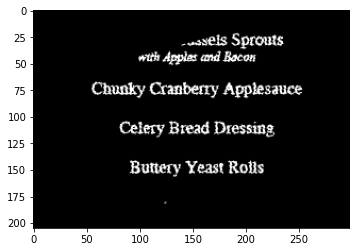

In [9]:
res = rotate_image(thresh,final_angle)
plt.imshow(res ,cmap='gray')

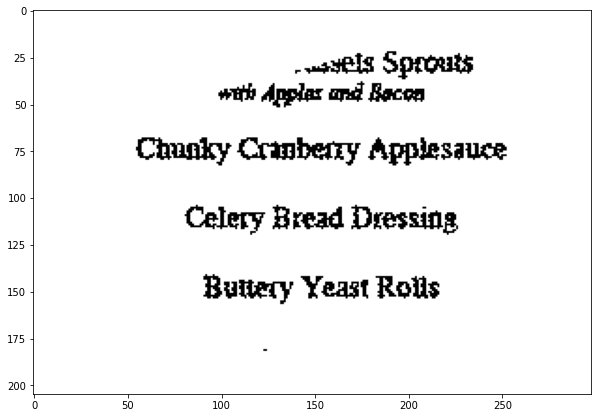

In [10]:
retval, thresh = cv2.threshold(res,100,255,cv2.THRESH_BINARY)

plt.figure(figsize=(10,10))
plt.imshow(255-thresh ,cmap='gray')

#### Dish Name Segmentation 

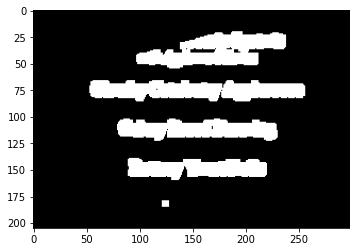

In [11]:

img = thresh

kernel = np.ones((6,6), np.uint8) 
op1 = cv2.dilate(img, kernel, iterations=1) 

plt.imshow( op1,cmap='gray')

In [12]:

def dish_name_segmentation(dilated_img ,img):
    
    num_labels, labels_im = cv2.connectedComponents(dilated_img)
    boxes = get_bounding_boxes(num_labels ,labels_im)
    
    segments = []
    
    for box in boxes:
        label = box[0]
        w = box[1]
        h = box[2]
        x = box[3]
        y = box[4]

        cropped = img[y-10:y+h+10 ,x-10:x+w+10]
    
        segments.append( [ 255-cropped , x,y,w,h ] )
        
    return segments 

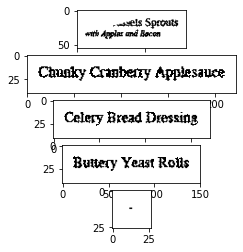

In [13]:
segs = dish_name_segmentation(op1 ,img)

f, plots = plt.subplots(len(segs),1)
counter = 0

for i in segs:
    plots[counter].imshow(i[0] ,cmap='gray')
    counter+=1

#### OCR

In [14]:
from PIL import Image
import pytesseract

final_text = []

for i in segs:
    PIL_image = Image.fromarray(i[0])
    text = pytesseract.image_to_string(PIL_image)

    temp = text.split('\x0c')[0]
    line = temp.split('\n')[0]

    for j in [line]:
        final_text.append([j ,i[1] ,i[2] ,i[3] ,i[4] ])
        
final_text

[['cwsvels Sprouts', 97, 20, 141, 35],
 ['Chunky Cranberry Applesauce', 53, 66, 203, 20],
 ['Celery Bread Dressing', 79, 102, 151, 21],
 ['Buttery Yeast Rois', 89, 139, 131, 21],
 ['', 121, 179, 7, 6]]

#### Database Creation 

In [15]:
import os
rootdir = '../img/menu_items'

db = []
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        temp = file.split('.')[0]
        db.append(temp) 

db 

['celery bread dressing',
 'pumpkin pie',
 'buttery yeast rolls',
 'slow-roasted heritage turkey',
 'pumpkin dip',
 'roasted brussels sprouts',
 'deviled eggs',
 'roasted garlic mashed potatoes',
 'percimmon pudding',
 'sweet potato casserole',
 'chunky cranberry applesauce']

#### OCR Correction 

In [16]:
def edit_distance(s1 ,s2 ,max_dist):
    l1 = len(s1)
    l2 = len(s2)
    
    dp = np.zeros((2 ,l1+1))
    
    for i in range(l1+1):
        dp[0][i] = i
        
    for i in range(1,l2+1):
        for j in range(0,l1+1):
            
            if j==0:
                dp[i%2][j] = i
            
            elif s1[j-1] == s2[i-1]:
                dp[i%2][j] = dp[(i-1)%2][j-1]
            
            else: 
                dp[i%2][j] = 1 + min(dp[(i-1)%2][j], min(dp[i%2][j-1], dp[(i-1)%2][j-1])) 
        
    
    dist = dp[l2%2][l1]
    
    if dist > max_dist:
        return max_dist+1
    
    return dist

In [17]:

def db_lookup(test_str , db ,max_dist):

    min_dist = sys.maxsize
    match = None 

    for i in db:
        dist = edit_distance(test_str ,i ,max_dist)

        if dist < min_dist:
            min_dist = dist
            match = i 

            if min_dist == 0 :
                break

    if min_dist < max_dist:
        return match 

In [18]:
def OCR_Correction( final_text ,max_dist):
    
    corrected_img = []
    
    for i in final_text:
        dish = i[0].lower()

        op = db_lookup(dish ,db ,max_dist)
        i.append(op)
        corrected_img.append(i)
        
    return corrected_img


In [19]:
dish_names = OCR_Correction(final_text , 4)
dish_names

[['cwsvels Sprouts', 97, 20, 141, 35, None],
 ['Chunky Cranberry Applesauce',
  53,
  66,
  203,
  20,
  'chunky cranberry applesauce'],
 ['Celery Bread Dressing', 79, 102, 151, 21, 'celery bread dressing'],
 ['Buttery Yeast Rois', 89, 139, 131, 21, 'buttery yeast rolls'],
 ['', 121, 179, 7, 6, None]]

#### Final Output Generation 

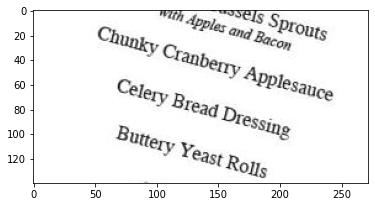

In [20]:
img = cv2.imread('../img/crop.jpeg' ,0)
plt.imshow(img ,cmap='gray')

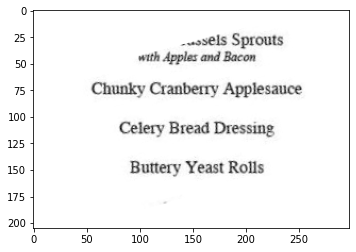

In [21]:
img = 255-img
res = rotate_image(img,final_angle)
res = 255- res
plt.imshow(res ,cmap='gray')

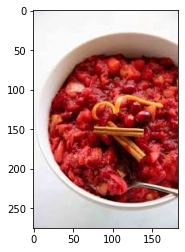

In [22]:
test = dish_names[1]

path = test[5]+'.jpeg'
w = test[3]
h = test[4]

dish_img = cv2.imread('../img/menu_items/' + path )
dish_img = cv2.cvtColor(dish_img, cv2.COLOR_BGR2RGB)

plt.imshow(dish_img ,cmap='gray')


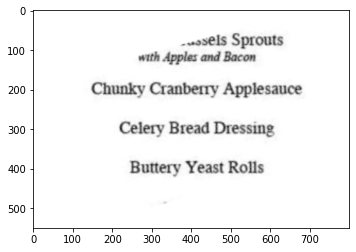

In [23]:
sz = res.shape
width = 800

hi ,wi = int(sz[0]*width/sz[1]) , width

cropped_img = cv2.resize(res ,(wi, hi))
plt.imshow(cropped_img ,cmap='gray')

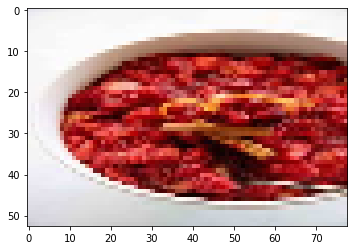

In [24]:
ratio = width/sz[1]

new_dish_img = cv2.resize(dish_img , (int((sz[1]*h*ratio)/sz[0])  ,int(h*ratio) ) )

plt.imshow(new_dish_img)

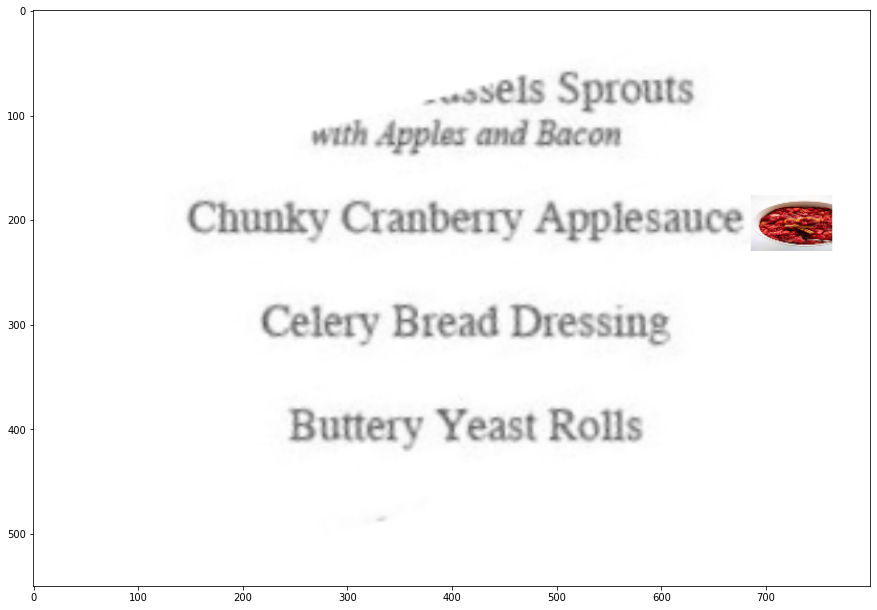

In [25]:
new_cropped_img = np.stack((cropped_img,)*3, axis=-1)

x,y,w,h = test[1] ,test[2] ,test[3] ,test[4]
x = int(x*ratio) 
y = int(y*ratio)
w = int(w*ratio)
h = int(h*ratio)

sz = new_dish_img.shape

new_cropped_img[ y:y+sz[0] ,x+w:x+w+sz[1],:] = new_dish_img[:,:,:]

plt.figure( figsize=(15,15))
plt.imshow(new_cropped_img)

In [43]:

def get_finla_output( menu , dish_names ,final_angle):
    img = 255-menu
    res = rotate_image(img,final_angle)
    res = 255- res
    
    siz = res.shape
    width = 800
    hi ,wi = int(siz[0]*width/siz[1]) , width
    cropped_img = cv2.resize(res ,(wi, hi))
    new_cropped_img = np.stack((cropped_img,)*3, axis=-1)
        
    for i in dish_names:
        test = i
        
        if test[5] != None:
            
            path = test[5]+'.jpeg'
            w = test[3]
            h = test[4]

            dish_img = cv2.imread('../img/menu_items/' + path )
            dish_img = cv2.cvtColor(dish_img, cv2.COLOR_BGR2RGB)
      
            ratio = width/siz[1]

            new_dish_img = cv2.resize(dish_img , (int((siz[1]*h*ratio)/siz[0])  ,int(h*ratio) ) )
    
            x,y,w,h = test[1] ,test[2] ,test[3] ,test[4]
            x = int(x*ratio) 
            y = int(y*ratio)
            w = int(w*ratio)
            h = int(h*ratio)

            sz = new_dish_img.shape
            
            new_cropped_img[ y:y+sz[0] ,x+w:x+w+sz[1],:] = new_dish_img[:,:,:]

    
    return new_cropped_img

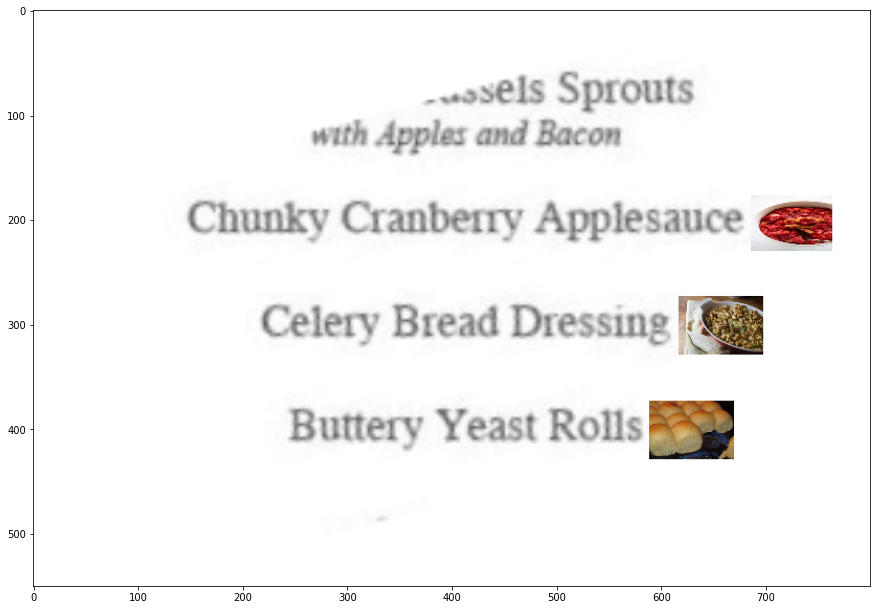

In [45]:
img = cv2.imread('../img/crop.jpeg' ,0)

op = get_finla_output(img ,dish_names ,final_angle)

plt.figure(figsize=(15,15))
plt.imshow(op)